<a href="https://colab.research.google.com/github/flexycode/CCMACLRL_EXERCISES_COM231ML/blob/main/Lab/Lab-Exercise-5/Exercise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Exercise 5: Create your own personal face recognition using SVM

## Instructions:

Create a directory in your google drive using this folder structure

```
My Drive
- Images
  - Train
    - Elizer
      - elizerimage1.jpg
      ...
    - Eliza
      - elizaimage1.jpg
      ...
    - Elijah
      - elijahimage1.jpg
      ...
  - Test
    - testimage1.jpg
    ...
```

- Upload 190 images of your self (selfied are recommended) in the Train folder
- Upload 190 images of your partner in the Train folder
- Upload 10 images each of yourself and your partner in the Test Folder (30 images total for each member)
- Use **.png** or **.jpg** or **.jpeg** images files

In [39]:
pip install numpy opencv-python scikit-learn pillow

## Import libraries

In [24]:
import os
import cv2
import numpy as np
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Mount Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Display one raw image directly from your drive

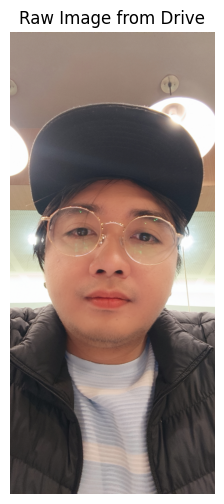

Image shape: (2436, 1080, 3)


In [26]:
def display_raw_image():
    # Update this path to match your directory structure
    image_path = '/content/drive/MyDrive/Images/Train/Jay Arre Talosig/jayarreimage1.jpg'

    try:
        # Load and display image
        img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title('Raw Image from Drive')
        plt.axis('off')
        plt.show()
        print(f"Image shape: {np.array(img).shape}")
    except Exception as e:
        print(f"Error loading image: {e}")
        print("Please check the file path and ensure the image exists")

display_raw_image()

## 2. Load the images from your drive and apply preprocessing to your raw images

In [27]:
def load_and_preprocess_images(base_path):
    images = []
    labels = []
    label_names = []

    # Get all subdirectories (person names)
    person_dirs = [d for d in os.listdir(base_path)
                   if os.path.isdir(os.path.join(base_path, d))]

    # Map person names to numeric labels
    label_map = {name: idx for idx, name in enumerate(person_dirs)}
    print(f"Found {len(person_dirs)} persons: {label_map}")

    for person_name in person_dirs:
        person_path = os.path.join(base_path, person_name)

        # Get all image files
        image_files = [f for f in os.listdir(person_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Loading {len(image_files)} images for {person_name}")

        for image_file in image_files:
            image_path = os.path.join(person_path, image_file)

            try:
                # Load image
                img = cv2.imread(image_path)
                if img is None:
                    continue

                # Convert BGR to RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize image to standard size
                img_resized = cv2.resize(img_rgb, (128, 128))

                # Convert to grayscale for simpler processing
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

                # Normalize pixel values
                img_normalized = img_gray / 255.0

                # Flatten the image
                img_flat = img_normalized.flatten()

                images.append(img_flat)
                labels.append(label_map[person_name])
                label_names.append(person_name)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue

    return np.array(images), np.array(labels), label_names, label_map

## Load Training data

In [28]:
train_path = '/content/drive/MyDrive/Images/Train'
X, y, label_names, label_map = load_and_preprocess_images(train_path)

print(f"Loaded {len(X)} training images")
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Found 4 persons: {'Moira Mercado': 0, 'Jay Arre Talosig': 1, 'James Adrian Castro': 2, 'Queen Maegan Pedido': 3}
Loading 200 images for Moira Mercado
Loading 201 images for Jay Arre Talosig
Loading 200 images for James Adrian Castro
Loading 190 images for Queen Maegan Pedido
Loaded 791 training images
Data shape: (791, 16384)
Labels shape: (791,)


## 3. Display one pre-processed image from the training set

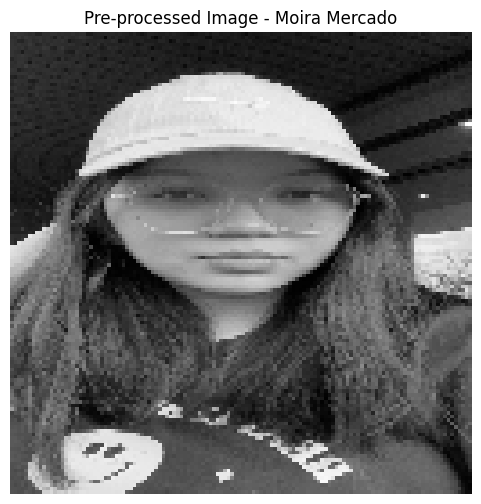

Image shape: (128, 128)
Label: Moira Mercado


In [29]:
def display_preprocessed_image(X, y, label_map):
    # Reverse label map for display
    reverse_label_map = {v: k for k, v in label_map.items()}

    # Get first image
    sample_image = X[0].reshape(128, 128)
    sample_label = y[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(sample_image, cmap='gray')
    plt.title(f'Pre-processed Image - {reverse_label_map[sample_label]}')
    plt.axis('off')
    plt.show()

    print(f"Image shape: {sample_image.shape}")
    print(f"Label: {reverse_label_map[sample_label]}")

display_preprocessed_image(X, y, label_map)

## 4. Display ten pre-processed images from the training set

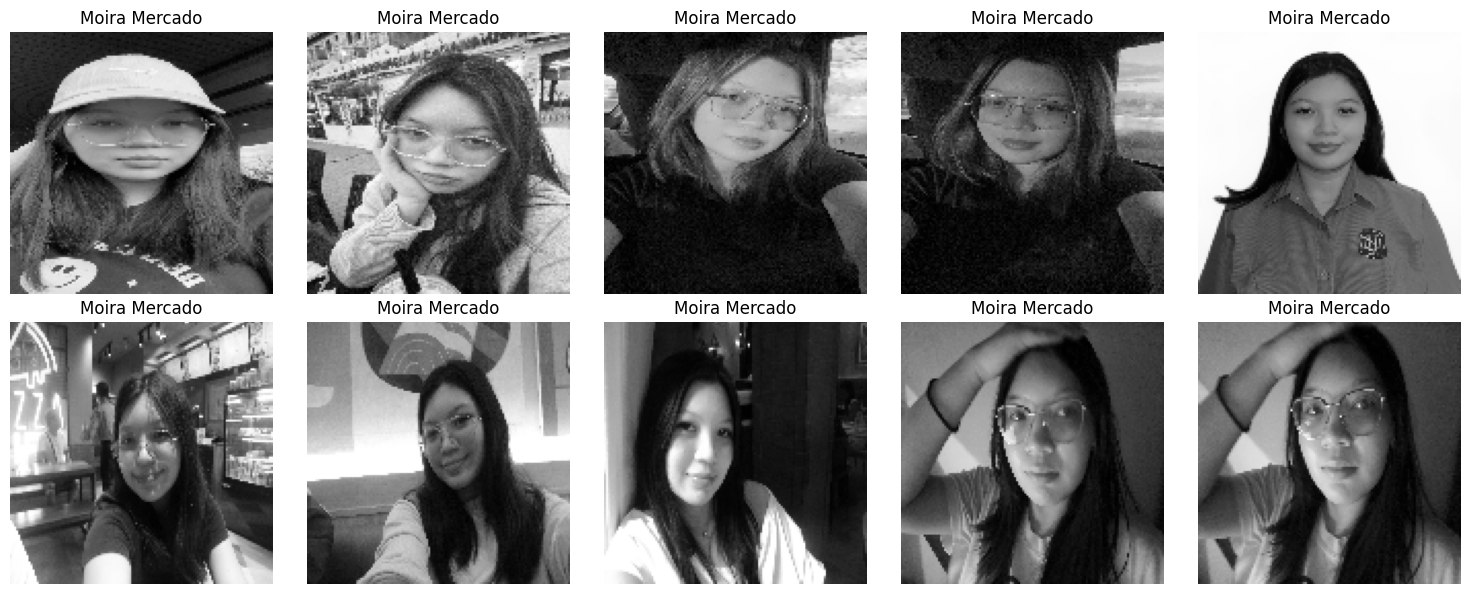

In [30]:
def display_ten_images(X, y, label_map):
    reverse_label_map = {v: k for k, v in label_map.items()}

    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(X[i].reshape(128, 128), cmap='gray')
        plt.title(f'{reverse_label_map[y[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_ten_images(X, y, label_map)

## 5. Split your training data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 632
Testing set size: 159
Number of features: 16384


## 6. Train your SVM model

In [41]:
def train_svm_model(X_train, y_train):
    # Create SVM classifier
    svm_classifier = svm.SVC(
        kernel='linear',  # You can try 'rbf', 'poly' for better results
        C=1.0,            # Regularization parameter
        random_state=42,
        probability=True  # Enable probability estimates
    )

    # Train the model
    print("Training SVM model...")
    svm_classifier.fit(X_train, y_train)
    print("Training completed!")

    return svm_classifier

### Train the model

In [33]:
svm_model = train_svm_model(X_train, y_train)

Training SVM model...
Training completed!


## 7. Evaluate your SVM model

Model Accuracy: 0.7925

Classification Report:
                     precision    recall  f1-score   support

      Moira Mercado       0.95      0.90      0.92        40
   Jay Arre Talosig       0.65      0.88      0.75        41
James Adrian Castro       0.77      0.57      0.66        40
Queen Maegan Pedido       0.86      0.82      0.84        38

           accuracy                           0.79       159
          macro avg       0.81      0.79      0.79       159
       weighted avg       0.81      0.79      0.79       159



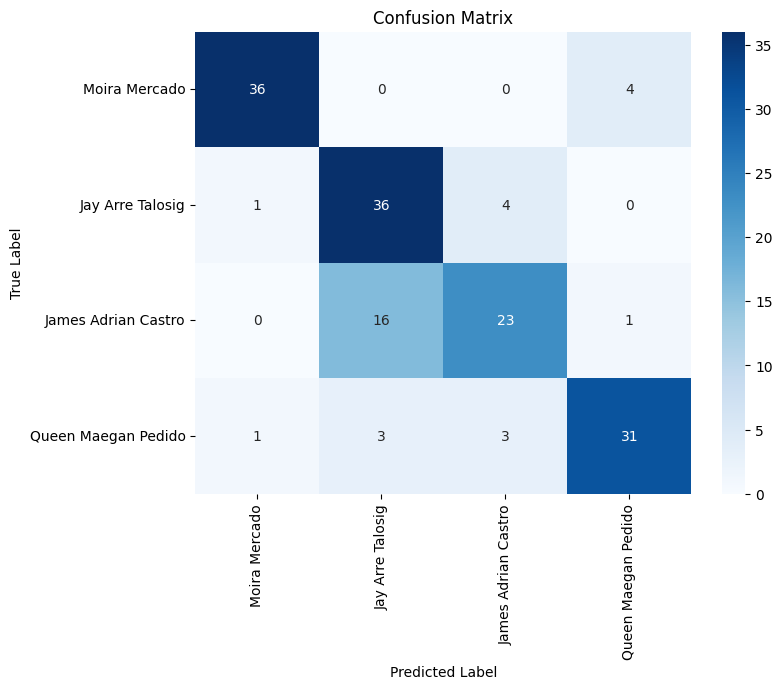

In [34]:
def evaluate_model(model, X_test, y_test, label_map):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    # Classification report
    reverse_label_map = {v: k for k, v in label_map.items()}
    target_names = [reverse_label_map[i] for i in range(len(label_map))]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

accuracy = evaluate_model(svm_model, X_test, y_test, label_map)

## 8. Test your model using images not in your training set

Use your SVM model to predict the label of all of your images in the Test folder

In [35]:
def test_on_new_images(model, test_folder_path, label_map):
    reverse_label_map = {v: k for k, v in label_map.items()}

    # Get all test images
    test_images = [f for f in os.listdir(test_folder_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(test_images)} test images")

    correct_predictions = 0
    total_predictions = 0

    plt.figure(figsize=(15, 10))

    for i, image_file in enumerate(test_images[:12]):  # Display first 12 images
        image_path = os.path.join(test_folder_path, image_file)

        try:
            # Preprocess the test image (same as training)
            img = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (128, 128))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
            img_normalized = img_gray / 255.0
            img_flat = img_normalized.flatten().reshape(1, -1)

            # Make prediction
            prediction = model.predict(img_flat)[0]
            prediction_prob = model.predict_proba(img_flat)[0]

            predicted_name = reverse_label_map[prediction]
            confidence = np.max(prediction_prob)

            # Try to extract true label from filename (assuming format: name_imageX.jpg)
            true_name_guess = image_file.split('_')[0] if '_' in image_file else "Unknown"

            # Display results
            plt.subplot(3, 4, i+1)
            plt.imshow(img_resized)
            plt.title(f'True: {true_name_guess}\nPred: {predicted_name}\nConf: {confidence:.2f}')
            plt.axis('off')

            # Check if prediction matches (if we can guess the true label)
            if true_name_guess in reverse_label_map.values():
                total_predictions += 1
                if predicted_name == true_name_guess:
                    correct_predictions += 1

        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    if total_predictions > 0:
        test_accuracy = correct_predictions / total_predictions
        print(f"Test Accuracy on new images: {test_accuracy:.4f} ({correct_predictions}/{total_predictions})")

### Test on new images

Found 40 test images


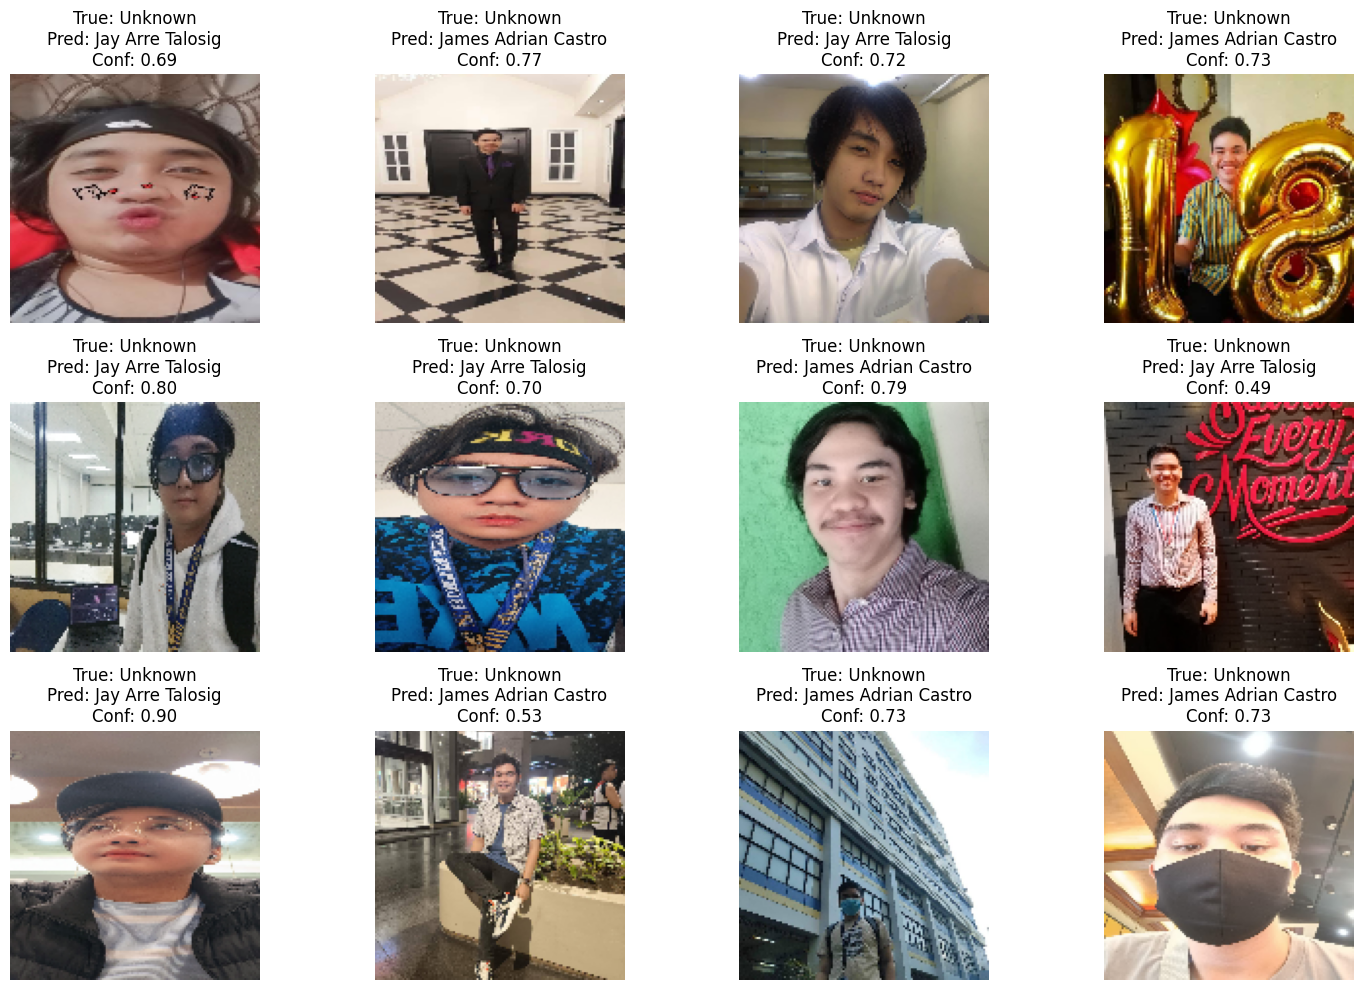

In [42]:
test_path = '/content/drive/MyDrive/Images/Test'
test_on_new_images(svm_model, test_path, label_map)

# Additional: Function to test individual images

In [37]:
def predict_single_image(model, image_path, label_map):
    reverse_label_map = {v: k for k, v in label_map.items()}

    try:
        # Preprocess the image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (128, 128))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        img_normalized = img_gray / 255.0
        img_flat = img_normalized.flatten().reshape(1, -1)

        # Make prediction
        prediction = model.predict(img_flat)[0]
        prediction_prob = model.predict_proba(img_flat)[0]

        predicted_name = reverse_label_map[prediction]
        confidence = np.max(prediction_prob)

        # Display results
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'Predicted: {predicted_name}\nConfidence: {confidence:.2f}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Prediction: {predicted_name}")
        print(f"Confidence: {confidence:.4f}")
        print("Probabilities:")
        for idx, prob in enumerate(prediction_prob):
            print(f"  {reverse_label_map[idx]}: {prob:.4f}")

    except Exception as e:
        print(f"Error processing image: {e}")

## Example usage for single image prediction

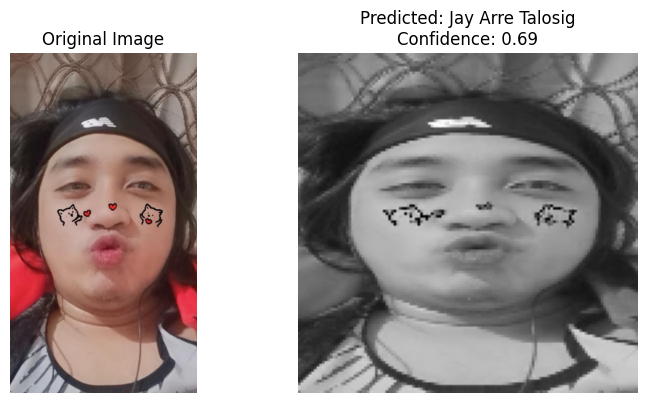

Prediction: Jay Arre Talosig
Confidence: 0.6865
Probabilities:
  Moira Mercado: 0.0177
  Jay Arre Talosig: 0.6865
  James Adrian Castro: 0.1465
  Queen Maegan Pedido: 0.1494


In [38]:
test_image_path = '/content/drive/MyDrive/Images/Test/testimage1.jpg'
predict_single_image(svm_model, test_image_path, label_map)